In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth

In [2]:
%matplotlib inline

In [3]:
movies = pd.read_csv('movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [4]:
ratings = pd.read_csv('ratings.csv')
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [5]:
movies_genres = []
for m in movies['genres']:
    movies_genres.append(m.split("|"))
# print(movies_genres)

te = TransactionEncoder()
te_ary = te.fit(movies_genres).transform(movies_genres)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df, min_support=0.1, use_colnames=True)

frequent_itemsets.sort_values(by=['support'], ascending=False)

,support,itemsets
3,0.447649,(Drama)
0,0.385547,(Comedy)
4,0.194416,(Thriller)
5,0.187641,(Action)
2,0.163827,(Romance)
1,0.129645,(Adventure)
6,0.123075,(Crime)
9,0.103983,"(Comedy, Drama)"
8,0.100595,(Sci-Fi)
7,0.100390,(Horror)


In [6]:
movies_genres = []
movies_genres_count = []

df_movies = pd.DataFrame(columns=['movies','count'])
for m in movies['genres']:
    movies_genres += m.split("|")
movies_genres = set(movies_genres)
movies_genres = list(movies_genres)

for g in movies_genres:
    g_count = len(movies[movies['genres'].str.contains(g)])
    df_movies = df_movies.append({'movies' : g,'count' : g_count},ignore_index=True)
print(movies_genres)
print(movies_genres_count)
df_movies = df_movies.sort_values(by=['count'], ascending=False)
df_movies

['Romance', 'Thriller', 'Crime', 'Film-Noir', 'Horror', 'Action', 'Mystery', '(no genres listed)', 'Musical', 'Children', 'Western', 'Animation', 'Fantasy', 'IMAX', 'War', 'Adventure', 'Drama', 'Comedy', 'Sci-Fi', 'Documentary']
[]


C:\Users\jenny\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,movies,count
16,Drama,4361
17,Comedy,3756
1,Thriller,1894
5,Action,1828
0,Romance,1596
15,Adventure,1263
2,Crime,1199
18,Sci-Fi,980
4,Horror,978
12,Fantasy,779


In [7]:
#輸入資料集、電影類型，回傳平均評分的分數
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre)]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1).reindex(avg_genre_votes_per_user.index)
        
    genre_ratings.columns = column_names
    return genre_ratings


In [8]:
# 每個用戶對所有浪漫類型電影平均評分;每個用戶對所有科幻類型電影平均評分
genre_ratings = get_genre_ratings(ratings, movies, ['Comedy', 'Drama'], ['avg_Comedy_rating', 'avg_Drama_rating'])
genre_ratings

,avg_Comedy_rating,avg_Drama_rating
userId,,
1,4.28,4.53
2,4.00,3.88
3,1.00,0.75
4,3.51,3.48
5,3.47,3.80
...,...,...
606,3.57,3.79
607,3.33,4.01
608,2.74,3.44


In [9]:
#刪除喜好不明確的數據
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_Comedy_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_Drama_rating'] > score_limit_2)) | ((genre_ratings['avg_Drama_rating'] < score_limit_1) & (genre_ratings['avg_Comedy_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset


In [10]:
#刻意增加一些數據噪音，以利分群
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2,2.5)
print( "Number of records: ", len(biased_dataset))
biased_dataset

Number of records:  106


,userId,avg_Comedy_rating,avg_Drama_rating
0,7,3.16,3.13
1,10,3.27,3.15
2,14,2.71,3.71
3,19,2.64,2.61
4,21,3.20,2.95
...,...,...,...
101,600,3.07,2.94
102,605,3.26,3.12
103,608,2.74,3.44
104,1,4.28,4.53


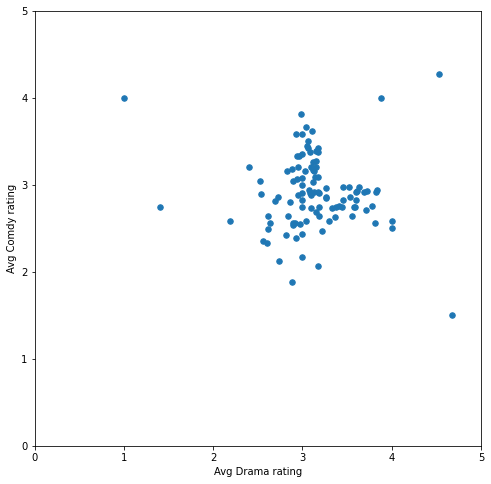

In [11]:
#將上述106筆資料進行視覺化分析，圖表呈現
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_Drama_rating'],'Avg Drama rating', biased_dataset['avg_Comedy_rating'], 'Avg Comdy rating')

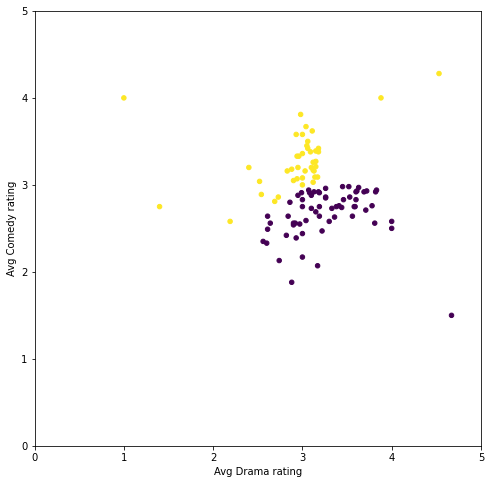

In [12]:
#進行分群：將所有用戶通過應用K-Means將樣本分解為兩個不同的組
# 若分兩群，如下圖
from sklearn.cluster import KMeans

#抓取訓練資料集
X = biased_dataset[['avg_Drama_rating','avg_Comedy_rating']].values

#K值為2
kmeans_1 = KMeans(n_clusters=2)
predictions = kmeans_1.fit_predict(X)

#畫圖
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg Drama rating')
    ax.set_ylabel('Avg Comedy rating')
    
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_Drama_rating'], clustered['avg_Comedy_rating'], c=clustered['group'], s=20, cmap=cmap)
    
# Plot
draw_clusters(biased_dataset, predictions)

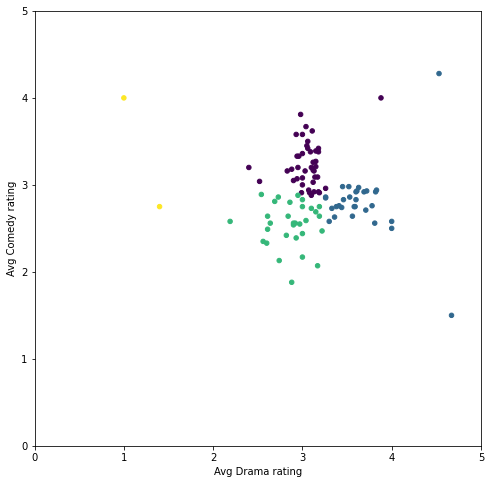

In [13]:
#K值為4
# 若分四群，如下圖，分越多每一群的用戶喜好越相似
kmeans_3 = KMeans(n_clusters=4)
predictions_3 = kmeans_3.fit_predict(X)
draw_clusters(biased_dataset, predictions_3)

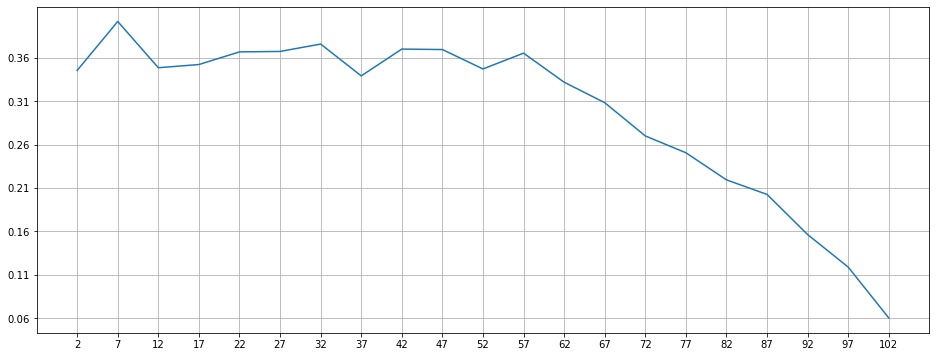

In [14]:
df = biased_dataset[['avg_Drama_rating','avg_Comedy_rating']] # 資料

possible_k_values = range(2, len(X)+1, 5)   # 定義k值取的範圍
# possible_k_values = range(2, len(X), 3)   # 定義k值取的範圍

# 定義計算函式
# 使用kmeans ; silhouette_score
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg
#計算，透過輪廓係數比較各K值選擇，哪個比較好。
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both') 

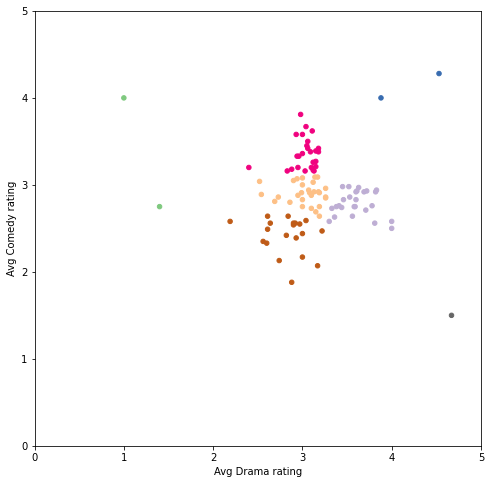

In [15]:
# 為了達到成效佳的分群，以及容易可視化。k值可解釋性，最後K值選擇7
kmeans_4 = KMeans(n_clusters=7)
predictions_4 = kmeans_4.fit_predict(X)
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

In [16]:
# 加入每位用戶對所有驚悚片資料平均評分
biased_dataset_3_genres = get_genre_ratings(ratings, movies,['Comedy','Drama', 'Thriller'],['avg_Comedy_rating', 'avg_Drama_rating', 'avg_Thriller_rating']) 
# Drop null values 
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna() 
# Print the number of records and the head of our dataset 
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()


Number of records:  106


,userId,avg_Comedy_rating,avg_Drama_rating,avg_Thriller_rating
0,7,3.16,3.13,3.43
1,10,3.27,3.15,3.08
2,14,2.71,3.71,3.46
3,19,2.64,2.61,2.55
4,21,3.20,2.95,3.55


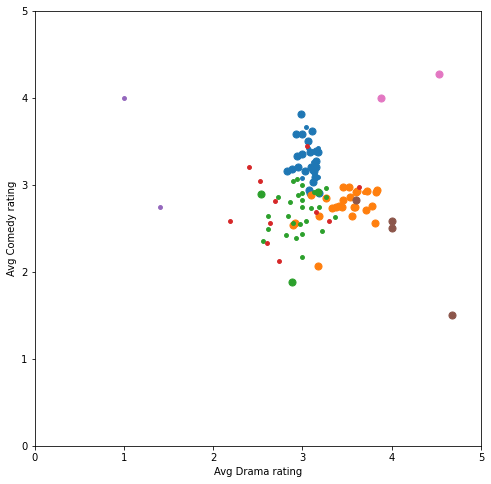

In [17]:
# 計算、圖表呈現：使用x軸和y軸的喜劇和劇情評分。繪製點的大小來表示驚悚片的評級（點越大，驚悚評級越高）
X_with_action = biased_dataset_3_genres[['avg_Drama_rating','avg_Comedy_rating','avg_Thriller_rating']].values 
kmeans_5 = KMeans(n_clusters=7) 
predictions_5 = kmeans_5.fit_predict(X_with_action) 
# Define 3d plotting function 
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5) 
    ax.set_xlabel('Avg Drama rating') 
    ax.set_ylabel('Avg Comedy rating') 
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1) 
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"]) 
    for g in clustered.group.unique(): 
        color = next(colors) 
        for index, point in clustered[clustered.group == g].iterrows(): 
            if point['avg_Thriller_rating'].astype(float) > 3: 
                size = 50 
            else: 
                size = 15 
            plt.scatter(point['avg_Drama_rating'], point['avg_Comedy_rating'], s=size, color=color)
            # Plot 
draw_clusters_3d(biased_dataset_3_genres, predictions_5)



In [18]:
#合併兩個資料表
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
# 印出資料集大小筆數；顯示資料
# 資料集中有許多NaN值，大部分用戶沒有做電影評分
print('資料集大小: ', user_movie_ratings.shape, '\n\n資料表:')
user_movie_ratings.iloc[:6, :10]

資料集大小:  (610, 9719) 

資料表:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# 定義函式取得評分最高的那些電影群的用戶
# 為了大部分用戶沒有做電影評分的問題，按評分高到低的電影的用戶對數據集進行排序。
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

In [20]:
# 定義函式取得評分最多的那些電影群的用戶
# 為了大部分用戶沒有做電影評分的問題，按評分多到少的電影的用戶對數據集進行排序。
def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

In [21]:
# 定義排序方式
#按評分最高的電影和評分最多電影的用戶對數據集進行排序
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies
# choose the number of movies and users and sort 
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)
# Print the result 
print('資料集大小: ', most_rated_movies_users_selection.shape) 
most_rated_movies_users_selection.head()

資料集大小:  (18, 30)


title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)"
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,3.0
589,5.0,4.5,4.5,3.5,4.0,5.0,4.0,4.0,4.5,5.0,...,4.5,5.0,4.0,3.5,4.0,5.0,4.5,4.0,4.0,3.5
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,...,4.0,5.0,5.0,4.0,3.0,5.0,5.0,4.0,4.0,5.0
479,5.0,5.0,4.0,4.5,5.0,4.5,5.0,5.0,4.5,5.0,...,3.5,5.0,3.5,4.5,4.5,4.5,4.0,4.0,4.0,4.0
67,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,4.0,...,5.0,4.0,4.5,4.0,4.0,4.0,4.5,3.5,2.5,2.5


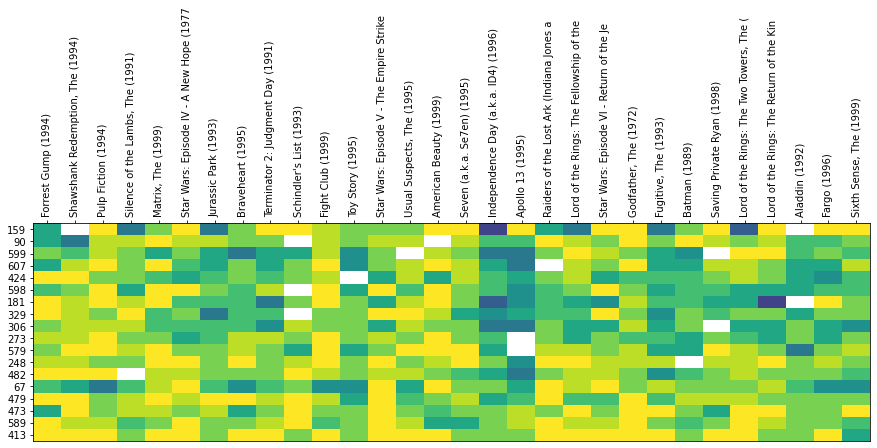

In [22]:
# Define the plotting heatmap function 
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True): 
    fig = plt.figure(figsize=(15,4)) 
    ax = plt.gca() 
    # Draw heatmap 
    heatmap = ax.imshow(most_rated_movies_users_selection, interpolation='nearest', vmin=0, vmax=5, aspect='auto') 
    if axis_labels: 
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False) 
        ax.invert_yaxis() 
        ax.xaxis.tick_top() 
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False) 
        plt.setp(ax.get_xticklabels(), rotation=90) 
    else: 
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False) 
        ax.grid(False) 
        ax.set_ylabel('User id') 
        # Separate heatmap from color bar 
        divider = make_axes_locatable(ax) 
        cax = divider.append_axes("right", size="5%", pad=0.05) 
        # Color bar 
        cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax) 
        cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars']) 
    plt.show() 
            # Print the heatmap 
draw_movies_heatmap(most_rated_movies_users_selection)

In [23]:
# Pivot the dataset and choose the first 1000 movies 
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating') 
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

In [24]:
# Conversion to sparse csr matrix 
sparse_rating = csr_matrix(most_rated_movies_1k)
sdf = pd.DataFrame.sparse.from_spmatrix(sparse_rating)
sparse_ratings = sdf.fillna(0).sparse.to_coo() #使用panda中的to_coo()方法將其轉換為稀疏矩陣。


In [25]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings) 

# Select the max number of users and movies heatmap cluster
max_users = 70
max_movies = 50 
# Cluster and print some of them 
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1) 

0


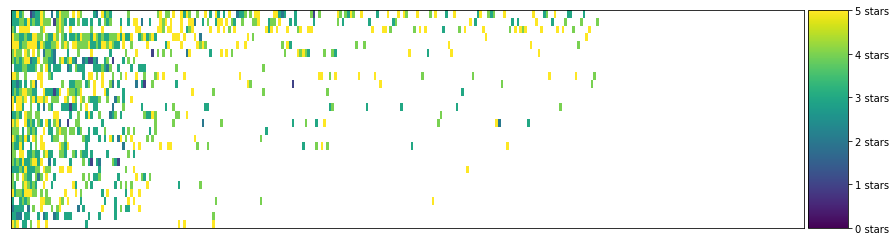

1


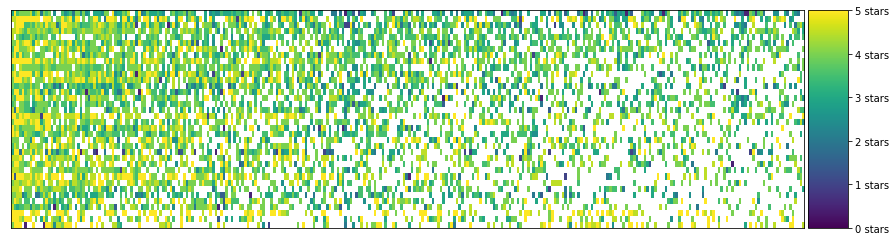

2


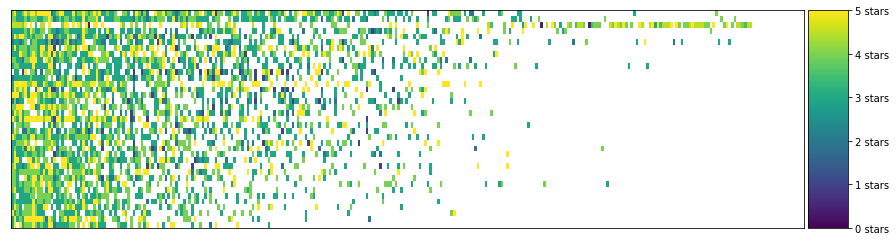

3


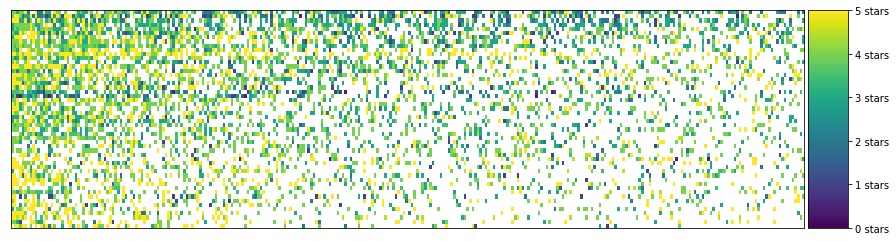

4


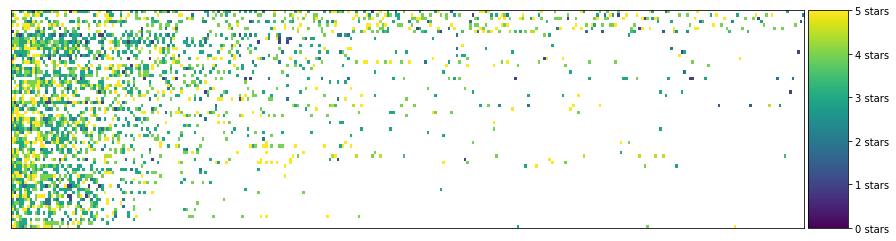

5


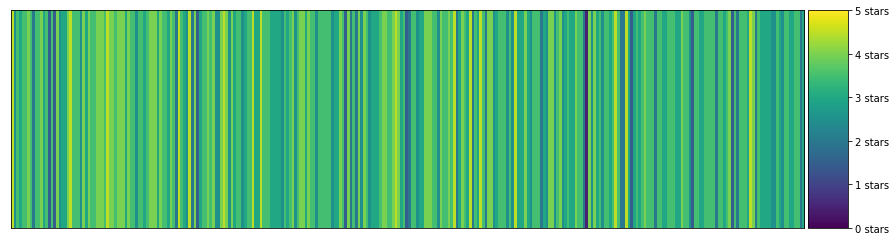

6


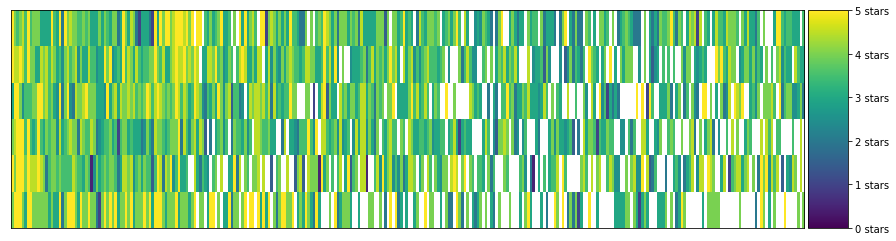

7


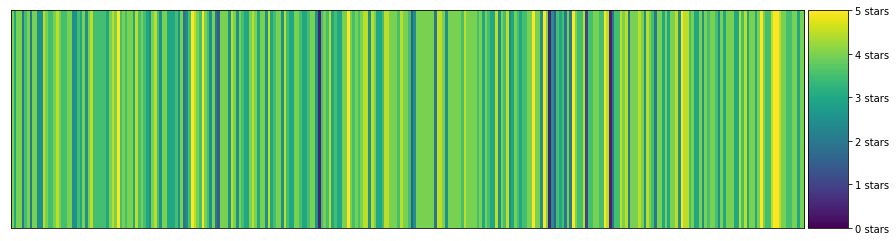

8


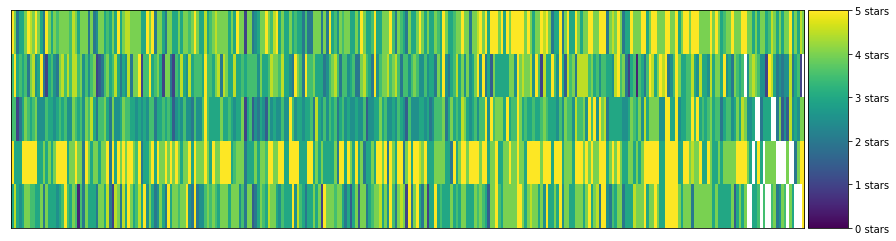

9


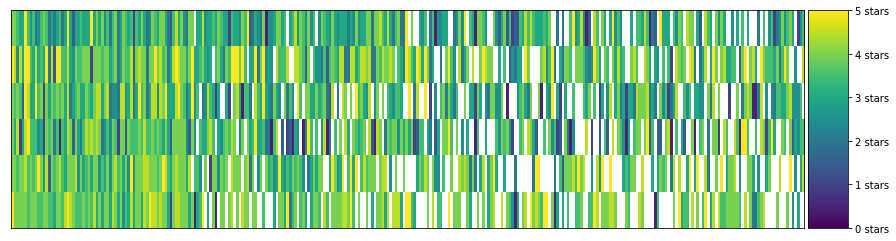

10


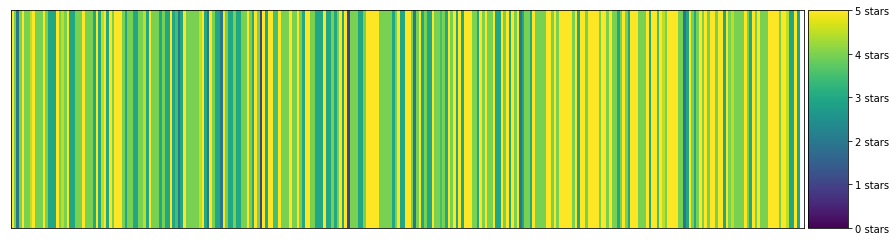

11


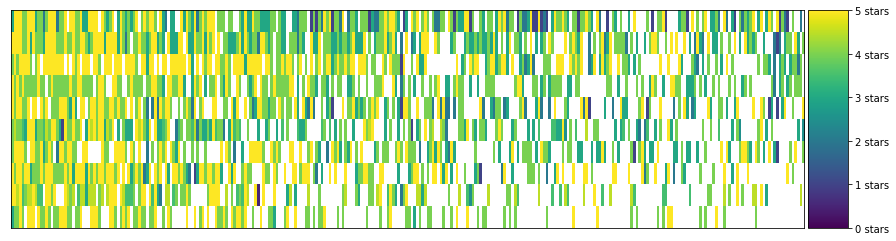

12


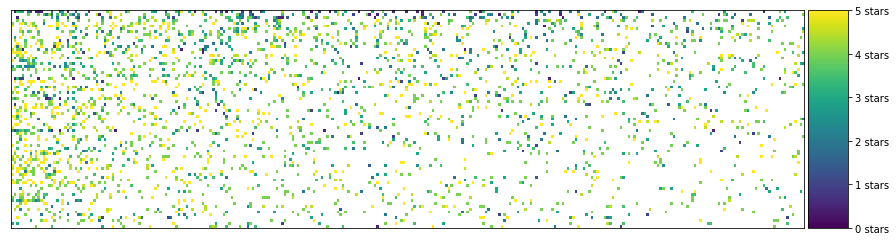

13


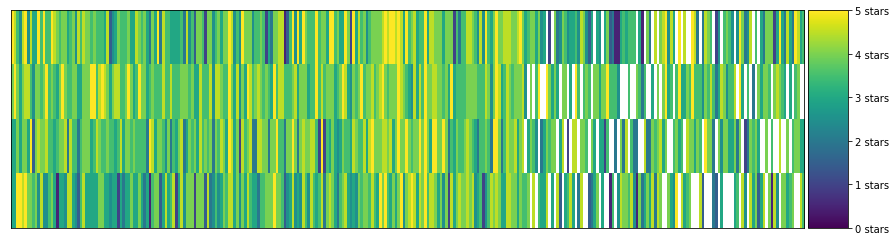

14


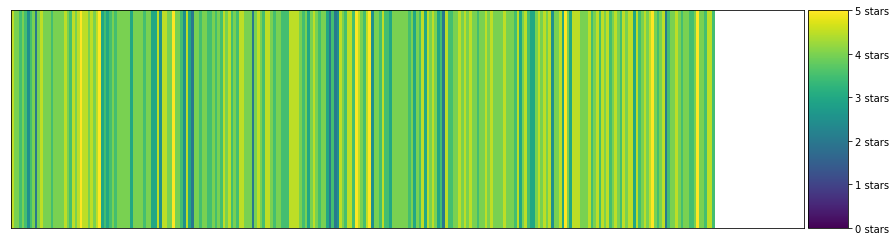

15


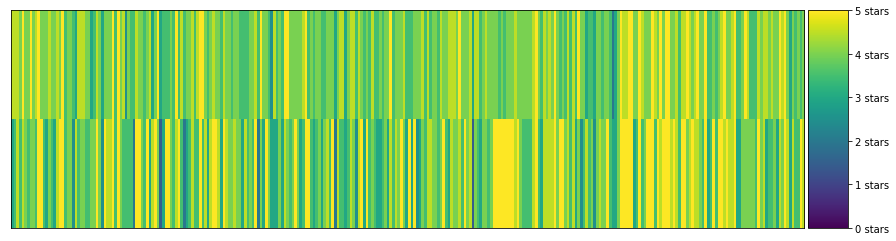

16


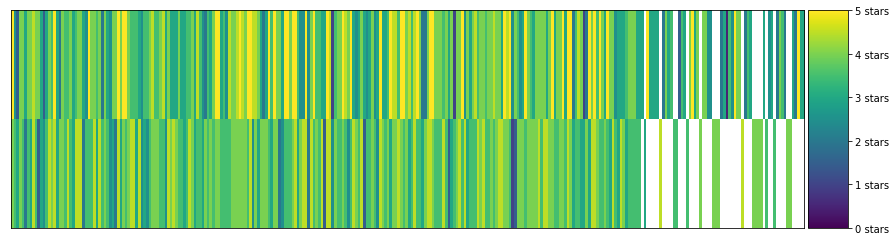

17


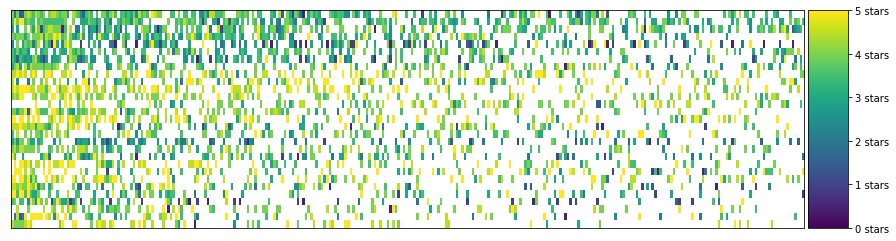

18


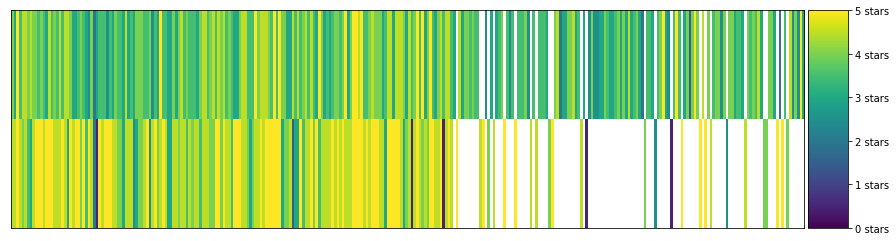

19


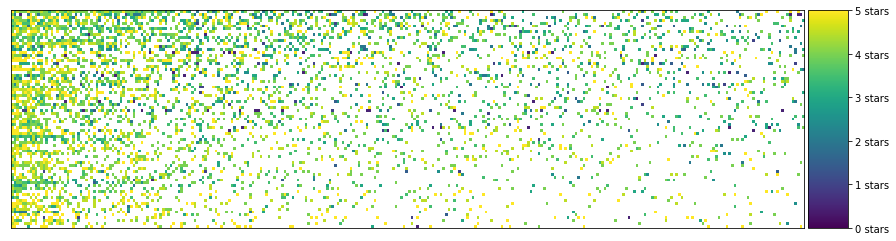

In [35]:
# 將所有聚類的熱力圖畫出
def get_culster(cluster_number):
    # Let's filter to only see the region of the dataset with the most number of values 
    n_users = 75
    n_movies = 300 
    cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1) 
    # Sort and print the cluster 
    cluster = sort_by_rating_density(cluster, n_movies, n_users)
    draw_movies_heatmap(cluster, axis_labels=False)
    return cluster
for c in range(0,20):
    print(c)
    get_culster(c)

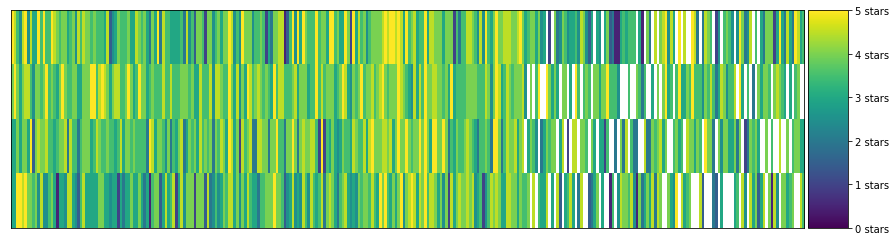

In [39]:
#選擇第13個聚類來分析
cluster = get_culster(13)

In [31]:
# Print the ratings 
cluster.fillna('').head()

,Forrest Gump (1994),"Life Aquatic with Steve Zissou, The (2004)",Requiem for a Dream (2000),"Matrix Reloaded, The (2003)","O Brother, Where Art Thou? (2000)",Office Space (1999),"Emperor's New Groove, The (2000)",Harry Potter and the Prisoner of Azkaban (2004),Armageddon (1998),"Bug's Life, A (1998)",...,Amadeus (1984),Insomnia (2002),Alien: Resurrection (1997),"Hunt for Red October, The (1990)","Mummy Returns, The (2001)",Meet the Parents (2000),Unforgiven (1992),Shakespeare in Love (1998),Star Wars: Episode II - Attack of the Clones (2002),"Nightmare Before Christmas, The (1993)"
2,5.0,4.5,3.5,2.5,4.5,5.0,2.5,4.5,3.0,3.0,...,5.0,3.0,2.0,4.5,3.0,2.0,5.0,4.5,3.0,3.5
0,4.0,5.0,4.0,3.0,4.0,4.5,4.5,3.5,2.5,4.0,...,4.0,3.5,3.0,,3.0,,3.5,4.0,,
1,3.0,3.0,4.0,3.0,4.0,4.0,3.0,5.0,1.5,4.0,...,4.5,,,4.0,,3.5,4.0,4.0,3.0,3.0
3,3.0,3.0,5.0,5.0,4.5,5.0,4.0,4.0,3.5,4.0,...,,4.0,4.0,3.0,3.5,4.0,,,4.5,3.5


In [38]:
# The average rating of 20 movies as rated by the users in the cluster 
cluster.mean().head(20).sort_values(ascending=False)

Office Space (1999)                                4.625
Harry Potter and the Prisoner of Azkaban (2004)    4.250
O Brother, Where Art Thou? (2000)                  4.250
Requiem for a Dream (2000)                         4.125
Gangs of New York (2002)                           4.125
Wizard of Oz, The (1939)                           4.000
Napoleon Dynamite (2004)                           4.000
Life Aquatic with Steve Zissou, The (2004)         3.875
Shrek 2 (2004)                                     3.875
Big (1988)                                         3.875
Jaws (1975)                                        3.875
Bug's Life, A (1998)                               3.750
Forrest Gump (1994)                                3.750
Lady and the Tramp (1955)                          3.625
Emperor's New Groove, The (2000)                   3.500
Willow (1988)                                      3.500
Beetlejuice (1988)                                 3.500
Matrix Reloaded, The (2003)    

In [32]:
# Fill in the name of the column/movie. e.g. 'Shrek (2001)'
movie_name = "Shrek (2001)" 
cluster[movie_name].mean()

4.0

In [34]:
# 在該用戶會喜歡的電影群中，推薦用戶未看過的電影，評分最高的前20部電影。
# Pick a user ID from the dataset 
user_id = 1
# Get all this user's ratings 
user_2_ratings = cluster.loc[user_id,:] 
# Which movies did they not rate? 
user_2_unrated_movies = user_2_ratings[user_2_ratings.isnull()]
# What are the ratings of these movies the user did not rate? 
# avg_ratings = pd.concat([user_2_unrated_movies,cluster.mean()], axis=1).loc[:,0]
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
# Let's sort by rating so the highest rated movies are presented first 
avg_ratings.sort_values(ascending=False)[:20]

Old School (2003)                          4.166667
Swingers (1996)                            3.833333
Ring, The (2002)                           3.833333
Zoolander (2001)                           3.666667
Crow, The (1994)                           3.666667
Insomnia (2002)                            3.500000
Dark Crystal, The (1982)                   3.500000
Hannibal (2001)                            3.500000
Jackie Brown (1997)                        3.500000
Dodgeball: A True Underdog Story (2004)    3.500000
Blow (2001)                                3.500000
Cable Guy, The (1996)                      3.500000
Basic Instinct (1992)                      3.333333
Go (1999)                                  3.166667
Pitch Black (2000)                         3.166667
Mummy Returns, The (2001)                  3.166667
Blade II (2002)                            3.166667
Road Trip (2000)                           3.000000
Saw (2004)                                 3.000000
Alien: Resur